In [246]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [184]:
vocab_size = 200
max_len = 5

src = tf.constant(np.random.rand(2,5))

In [185]:
src.shape

TensorShape([2, 5])

In [181]:
class InputEmbedding(tf.keras.Model):
    
    def __init__(self,vocab_size,emb_size,input_length):
        
        super().__init__()
        self.emb_size = emb_size
        self.vocab_size= vocab_size
        
        self.input_emb = Embedding(
                        input_dim = self.vocab_size,
                        output_dim = self.emb_size,
                        input_length = input_length
                                  )
        
    
    def __call__(self,x):
        
        return  self.input_emb(x)
        
        

In [236]:
class PositionalEmbedding(tf.keras.Model):
    def __init__(self,batch_size,seq_len,emb_size):
        
        positions = np.arange(seq_len)[:,np.newaxis]
        depth = np.arange(emb_size)[np.newaxis, :]
        depth = (2*depth//2)/emb_size

        angle_rates = 1 / (10000**depth)

        angle_rads  = positions * angle_rates
        angle_rads[:,0::2] = np.sin(angle_rads[:,0::2])
        angle_rads[:,1::2] = np.sin(angle_rads[:,1::2])


        positions = positions * angle_rads
           
        self.pos = tf.constant(np.broadcast_to(positions,[batch_size,seq_len,emb_size]))
        
        
    def get_pos_emb(self):
        return self.pos
        
        
            
    

In [244]:
seq_len = 1000

positions = PositionalEmbedding(2,seq_len,512).get_pos_emb()
positions.shape

TensorShape([2, 1000, 512])

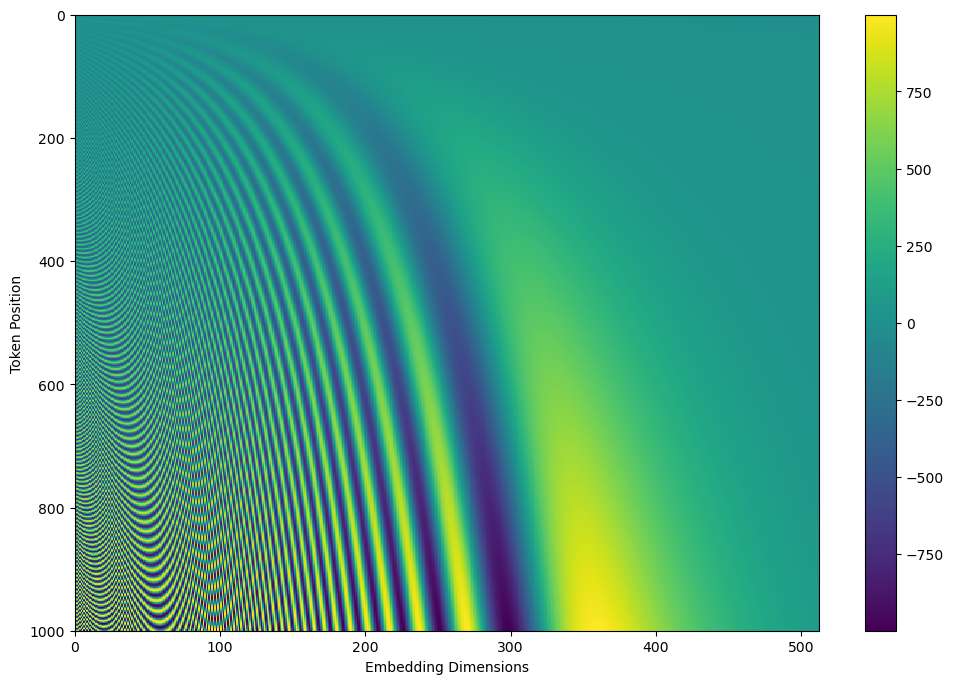

In [245]:
plt.figure(figsize=(12,8))
plt.pcolormesh(positions[0], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, 512))
plt.ylim((seq_len,0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

In [ ]:
class InputEmbedding(tf.keras.Model):
    
    def _init_(self,vocab_size,emb_size,input_length):
        
        super()._init_()
        self.emb_size = emb_size
        self.vocab_size= vocab_size
        
        self.input_emb = Embedding(
                        input_dim = self.vocab_size,
                        output_dim = self.emb_size,input_length = input_length
                                  )
        
    
    def _call_(self,x):
        
        return  self.input_emb(x)
        
        class PositionalEmbedding(tf.keras.Model):
    def _init_(self,batch_size,seq_len,emb_size):
        
        positions = np.arange(seq_len)[:,np.newaxis]
        depth = np.arange(emb_size)[np.newaxis, :]
        depth = (2*depth//2)/emb_size

        angle_rates = 1 / (10000**depth)

        angle_rads  = positions * angle_rates
        angle_rads[:,0::2] = np.sin(angle_rads[:,0::2])
        angle_rads[:,1::2] = np.sin(angle_rads[:,1::2])


        positions = positions * angle_rads
           
        self.pos = tf.constant(np.broadcast_to(positions,[batch_size,seq_len,emb_size]))
        
        
    def get_pos_emb(self):
        return self.pos

# MultiHeaded Attention

In [365]:
vector = np.random.rand(10,5,512)
q = tf.constant(vector)
k = tf.constant(vector)
v = tf.constant(vector)

In [366]:
q = tf.reshape(q,(10,8,5,64))
k = tf.reshape(k,(10,8,5,64))
v = tf.reshape(v,(10,8,5,64))

q.shape, v.shape, k.shape

(TensorShape([10, 8, 5, 64]),
 TensorShape([10, 8, 5, 64]),
 TensorShape([10, 8, 5, 64]))

In [367]:
out = np.zeros([10,8,5,64])
out.shape

(10, 8, 5, 64)

In [360]:
for h in range(q.shape[0]):
    for i in range(q.shape[1]):
        scores = tf.keras.layers.Dot(axes=-1)([q[h,i,:][tf.newaxis,:], k[h,:,:][tf.newaxis,:]])
        z = tf.keras.activations.softmax(scores)
        value_vectors = tf.cast(tf.transpose(v[h,:,:]),dtype=tf.float32) * tf.cast(scores,dtype=tf.float32)
        out[h,i,:] = tf.reduce_sum(value_vectors,axis=-1)
        

In [364]:
out.reshape(5,512).shape

(5, 512)

In [368]:
# batch size
for b in range(q.shape[0]):
    for h in range(q.shape[1]):
        for i in range(q.shape[2]):
            scores = tf.keras.layers.Dot(axes=-1)([q[b,h,i,:][tf.newaxis,:], k[b,h,:,:][tf.newaxis,:]])
            
            z = tf.keras.activations.softmax(scores)
            
            value_vectors = tf.cast(tf.transpose(v[b,h,:,:]),dtype=tf.float32) * tf.cast(scores,dtype=tf.float32)
            
            out[b,h,i,:] = tf.reduce_sum(value_vectors,axis=-1)


In [374]:
tf.reshape(out,(10,5,512)).shape

TensorShape([10, 5, 512])

In [370]:
tf.constant(out).shape

TensorShape([10, 8, 5, 64])

In [412]:
class MultiHeadAttention(tf.keras.Model):
    
    def __init__(self,emb_size,batch_size,heads,seq_len):
        super(MultiHeadAttention,self).__init__()
        
        
        """"
        Parameters:
                emb_size (int): Embedding size (e.g 512)
                batch_size (int): Batch Size
                heads (int): Number of heads (e.g 8)
                seq_len (int): Number of words in each sequence
                
        Returns:
            Out (Tensor)
        
        """
        self.emb_size= emb_size
        self.heads = heads
        self.head_dim = emb_size//heads
        self.seq_len = seq_len
        self.batch_size = batch_size
        
        # Queries, Keys and Values Matrices Layers
        self.queries = tf.keras.layers.Dense(self.emb_size)
        self.keys = tf.keras.layers.Dense(self.emb_size)
        self.values = tf.keras.layers.Dense(self.emb_size)
        
    
    def SelfAttenion(self,queries,keys,values):
       
        out = np.zeros([self.batch_size,self.heads,self.seq_len,self.head_dim])
        
        # apply attetion mechanism
        for b in range(self.batch_size):
            for h in range(self.heads):
                for i in range(self.seq_len):
                    # Calculating the scores by multiplying Query with key
                    scores = tf.keras.layers.Dot(axes=-1)([q[b,h,i,:][tf.newaxis,:], k[b,h,:,:][tf.newaxis,:]])
                    
                    # apply Softmax
                    z = tf.keras.activations.softmax(scores)
                    
                    # Normalize the scores
                    z = z/np.sqrt(self.head_dim)
                    
                    # Multiply the score with value vectors
                    value_vectors = tf.cast(tf.transpose(v[b,h,:,:]),dtype=tf.float32) * tf.cast(scores,dtype=tf.float32)
                    
                    
                    out[b,h,i,:] = tf.reduce_sum(value_vectors,axis=-1)

        return tf.reshape(out,(self.batch_size,self.seq_len,self.emb_size))
    
    def __call__(self,x):
        
        
        # As mention in the paper first we multiply each word embedding in our case 512 with 512x512 Matrcis
        # We pass our data through the dense layer
        queries = self.queries(x)
        keys = self.keys(x)
        values = self.values(x)
        
        # Self Attention
        attention = self.SelfAttenion(queries,keys,values)
        
        # Last matrix 
        
        out = tf.keras.layers.Dense(self.emb_size)(attention)
                          
        return out

In [414]:
x = np.random.rand(10,5,512)
tf.keras.layers.Dense(512)(x).shape

TensorShape([10, 5, 512])

In [415]:
mha = MultiHeadAttention(512,10,8,5)

In [416]:
out = mha(x)

In [418]:
out.shape

TensorShape([10, 5, 512])